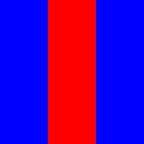

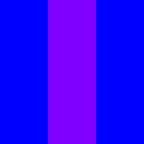


ЗАПУСК ЭКСПЕРИМЕНТА: размер (3, 3), расстояние Хэмминга

Размер матрицы: (3, 3), расстояние: Хэмминга
Потребовалось поколений: 3

Эталонное изображение:

Финальный результат:

Процесс эволюции:

ЗАПУСК ЭКСПЕРИМЕНТА: размер (3, 3), расстояние Евклидово

Размер матрицы: (3, 3), расстояние: Евклидово
Потребовалось поколений: 9

Эталонное изображение:

Финальный результат:

Процесс эволюции:

ЗАПУСК ЭКСПЕРИМЕНТА: размер (5, 5), расстояние Хэмминга

Размер матрицы: (5, 5), расстояние: Хэмминга
Потребовалось поколений: 3

Эталонное изображение:

Финальный результат:

Процесс эволюции:

ЗАПУСК ЭКСПЕРИМЕНТА: размер (5, 5), расстояние Евклидово

Размер матрицы: (5, 5), расстояние: Евклидово
Потребовалось поколений: 16

Эталонное изображение:

Финальный результат:

Процесс эволюции:

ЗАПУСК ЭКСПЕРИМЕНТА: размер (9, 9), расстояние Хэмминга

Размер матрицы: (9, 9), расстояние: Хэмминга
Потребовалось поколений: 4

Эталонное изображение:

Финальный результат:

Процесс эволюции:

ЗАПУСК ЭКСПЕРИМЕНТА


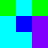

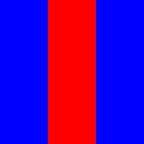

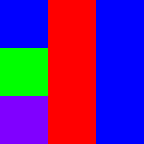


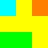

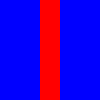

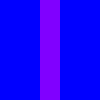


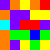

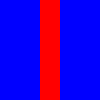

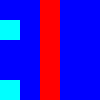


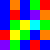

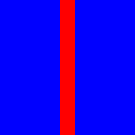

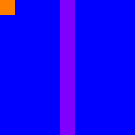


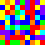

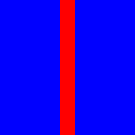

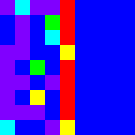


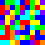

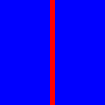

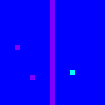


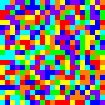

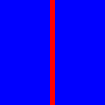

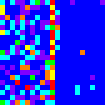


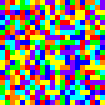

Dict{Any, Any} with 8 entries:
  ((5, 5), false)   => [16.4621, 15.6844, 15.6525, 14.3178, 14.0357, 12.2474, 1…
  ((9, 9), true)    => [19.0, 12.0, 11.0, 10.0]
  ((9, 9), false)   => [23.6854, 23.2379, 22.8254, 22.6495, 22.2261, 21.8632, 2…
  ((3, 3), true)    => [8.0, 4.0, 3.0]
  ((3, 3), false)   => [8.0, 6.9282, 6.40312, 5.74456, 5.0, 4.47214, 3.4641, 3.…
  ((21, 21), true)  => [203.0, 73.0, 35.0, 34.0, 32.0, 30.0, 24.0]
  ((21, 21), false) => [53.5257, 47.4025, 47.1275, 47.0638, 42.1545, 35.242, 33…
  ((5, 5), true)    => [22.0, 6.0, 5.0]

In [ ]:
using Random
using Images
using FileIO
using Base64
using Statistics

function get_rainbow_palette()
    return [
        RGB(1.0, 0.0, 0.0),  # красный
        RGB(1.0, 0.5, 0.0),  # оранжевый
        RGB(1.0, 1.0, 0.0),  # желтый
        RGB(0.0, 1.0, 0.0),  # зеленый
        RGB(0.0, 1.0, 1.0),  # голубой
        RGB(0.0, 0.0, 1.0),  # синий
        RGB(0.5, 0.0, 1.0)   # фиолетовый
    ]
end

function matrix_to_image(matrix, palette; pixel_size=30)
    h, w = size(matrix)
    img = Array{RGB{Float64}}(undef, h*pixel_size, w*pixel_size)
    for i in 1:h, j in 1:w,
        ii in ((i-1)*pixel_size+1):i*pixel_size,
        jj in ((j-1)*pixel_size+1):j*pixel_size
        
        idx = clamp(matrix[i, j], 1, length(palette))
        img[ii, jj] = palette[idx]
    end
    return img
end

function matrix_to_binary(matrix, bits_per_element=3)
    binary_vec = Bool[]
    for elem in matrix
        val = elem - 1
        for i in (bits_per_element-1):-1:0
            push!(binary_vec, val & (1 << i) != 0)
        end
    end
    return binary_vec
end

function binary_to_matrix(binary_vec, bits_per_element, matrix_size)
    matrix = zeros(Int, matrix_size)
    for i in 1:prod(matrix_size)
        bits = binary_vec[(i-1)*bits_per_element+1:i*bits_per_element]
        val = sum(bits .* [4, 2, 1])
        matrix[i] = clamp(val + 1, 1, 7)
    end
    return matrix
end

function crossover(a, b)
    n = length(a)
    child = similar(a)
    crossover_point = rand(1:n-1)
    child[1:crossover_point] = a[1:crossover_point]
    child[crossover_point+1:end] = b[crossover_point+1:end]
    return child
end

function mutate(binary_vec, mutation_rate=0.01)
    mutated = copy(binary_vec)
    for i in eachindex(mutated)
        rand() < mutation_rate && (mutated[i] = !mutated[i])
    end
    return mutated
end

function calculate_distance(a, b, use_hamming)
    if use_hamming
        return sum(a .!= b)
    else
        return sqrt(sum((a .- b).^2))
    end
end

function show_gif(frames, fps=5; display_size=400)
    gif = cat(frames..., dims=3)
    temp_file = tempname() * ".gif"
    save(temp_file, gif, fps=fps)
    
    w, h = size(frames[1])
    aspect_ratio = w/h
    display_width = display_size
    display_height = round(Int, display_size / aspect_ratio)
    
    display("text/html", """
    <div style="width:$(display_width)px; height:$(display_height)px; image-rendering: pixelated;">
        <img src="data:image/gif;base64,$(base64encode(open(read, temp_file)))" 
             width="$(display_width)" height="$(display_height)"
             style="image-rendering: pixelated;">
    </div>
    """)
end

function create_custom_matrix(matrix_size)
    matrix = fill(6, matrix_size)
    center_col = div(matrix_size[2], 2) + 1
    matrix[:, center_col] .= 0
    return matrix
end

function run_experiment(matrix_size, use_hamming; 
                       max_generations=500, mutation_rate=0.02, pixel_size=20)
    palette = get_rainbow_palette()
    bits_per_element = 3
    
    reference = create_custom_matrix(matrix_size)
    current = rand(1:7, matrix_size)
    
    frames = [matrix_to_image(current, palette; pixel_size)]
    distances = Float64[]
    
    generation = 0
    while generation < max_generations
        child_bin = mutate(crossover(matrix_to_binary(current), matrix_to_binary(reference)), mutation_rate)
        child = binary_to_matrix(child_bin, bits_per_element, matrix_size)
        
        dist = calculate_distance(current, reference, use_hamming)
        new_dist = calculate_distance(child, reference, use_hamming)

        if new_dist < dist
            current = child
            push!(frames, matrix_to_image(current, palette; pixel_size))
            push!(distances, new_dist)
        end
        generation += 1
        (new_dist == 0) && break
    end
    
    println("\nРазмер матрицы: $matrix_size, расстояние: $(use_hamming ? "Хэмминга" : "Евклидово")")
    println("Потребовалось поколений: $(length(distances))")
 
    if prod(matrix_size) <= 21*21
        println("\nЭталонное изображение:")
        display(matrix_to_image(reference, palette; pixel_size))
        
        println("\nФинальный результат:")
        display(matrix_to_image(current, palette; pixel_size))
        
        println("\nПроцесс эволюции:")
        show_gif(frames, 5; display_size=min(600, pixel_size * maximum(matrix_size) * 2))
    end
    
    return distances
end

function run_all_experiments()
    matrix_sizes = [(3,3), (5,5), (9,9), (21,21)]
    distance_types = [true, false]
    
    results = Dict()
    
    for size in matrix_sizes, use_hamming in distance_types
        println("\n" * "="^50)
        println("ЗАПУСК ЭКСПЕРИМЕНТА: размер $size, расстояние $(use_hamming ? "Хэмминга" : "Евклидово")")
        
        distances = run_experiment(size, use_hamming, 
                                 max_generations=1000,
                                 mutation_rate=0.01,
                                 pixel_size=max(5, 50 ÷ maximum(size)))
        
        results[(size, use_hamming)] = distances
    end
    
    return results
end

results = run_all_experiments()